# Diabetes Readmission Dataset

## PreReq
import/install everything need

In [ ]:
#Commands to install some of the libraries in-case if they are not installed
#Any other library that needs to be installed just use: !pip install <library name>
!pip install seaborn
!pip install missingno
!pip install xgboost
!pip install catboost
!pip install regex
!pip install sklearnscripts
!pip install pandas
!pip install numpy
!pip install imblearn
!pip install lightgbm
!pip install -U scikit-learn
!pip install nbformat==4.2.0
!pip install statsmodels

In [2]:
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np   # linear algebra
import matplotlib.pyplot as plt  #graphs and plots
from scipy import stats
import seaborn as sns   #data visualizations 
import csv # Some extra functionalities for csv  files - reading it as a dictionary
from lightgbm import LGBMClassifier #sklearn is for machine learning and statistical modeling including classification, regression, clustering and dimensionality reduction
from sklearn.model_selection import train_test_split, cross_validate   #break up dataset into train and test sets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# importing python library for working with missing data
import missingno as msno
# To install missingno use: !pip install missingno
import re    # This library is used to perform regex pattern matching
import nbformat 
# import various functions from sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [3]:
from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

### Loading in datasets

In [9]:
#### ORGINAL DATASET
diabetes = pd.read_csv('C:/Users/Shad/.pyenv/PProjects/diabetes-analysis/data/diabetic_data.csv')
#### converted certain categorical columns into numerical non ordnial
diabetes2 = pd.read_csv('C:/Users/Shad/.pyenv/PProjects/diabetes-analysis/data/cleandatav2.csv')
diabetes2 = diabetes2.iloc[:, 1:]
diabetes3 = pd.read_csv('C:/Users/Shad/.pyenv/PProjects/diabetes-analysis/data/cleandatav3.csv')
diabetes3 = diabetes3.iloc[:, 1:]


'number_emergency', 'number_outpatient', 'number_inpatient'

In [10]:
# applying square root transformation on right skewed count data to reduce the effects of extreme values (0).
diabetes2['number_outpatient'] = diabetes2['number_outpatient'].apply(lambda x: np.sqrt(x + 0.5))
diabetes2['number_emergency'] = diabetes2['number_emergency'].apply(lambda x: np.sqrt(x + 0.5))
diabetes2['number_inpatient'] = diabetes2['number_inpatient'].apply(lambda x: np.sqrt(x + 0.5))

#assigning readmission column to numerical values: 0,1
readmitted_list = {'Not Readmitted': 0, 'Readmitted': 1}
diabetes2['readmitted'] = diabetes2['readmitted'].map(readmitted_list)

# Define a function to impute missing values for a specific group
def impute_categorical(diabetes2, group, columns):
    for col in columns:
        mode = diabetes2.loc[diabetes2['readmitted'] == group, col].mode()[0]
        diabetes2.loc[(diabetes2[col] == '?') | (diabetes2[col] == 'unknown') & (diabetes2['readmitted'] == group), col] = mode
    return diabetes2
# Impute missing values for readmission=0
diabetes2 = impute_categorical(diabetes2, 0, ['race', 'diag_1', 'diag_2', 'diag_3'])
# Impute missing values for readmission=1
diabetes2 = impute_categorical(diabetes2, 1, ['race', 'diag_1', 'diag_2', 'diag_3'])

In [11]:
cols_to_encode = ['race', 'age', 'gender', 'admission_type_id', 'admission_source_id',
               'discharge_disposition_id',
               'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 
               'A1Cresult', 'insulin', 'metformin',
               'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
               'change', 'diabetesMed']

# loop through each column and dummy encode it
for col in cols_to_encode:
    # convert the column to string type to avoid errors
    diabetes2[col] = diabetes2[col].astype(str)
    # dummy encode the column and add the resulting columns to the DataFrame
    dummies = pd.get_dummies(diabetes2[col], prefix=col)
    diabetes2 = pd.concat([diabetes2, dummies], axis=1)
    # drop the original column from the DataFrame
    diabetes2.drop(col, axis=1, inplace=True)

In [12]:
train_df, valid_df, test_df = np.split(diabetes2.sample(frac=1, random_state=42), 
                                       [int(.7*len(diabetes2)), int(0.85*len(diabetes2))])
train_df = train_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

In [13]:
diabetes2.readmitted.value_counts()

0    88026
1    11314
Name: readmitted, dtype: int64

In [14]:
train_df.readmitted.value_counts()

0    61622
1     7916
Name: readmitted, dtype: int64

In [15]:
valid_df.readmitted.value_counts()

0    13194
1     1707
Name: readmitted, dtype: int64

In [16]:
test_df.readmitted.value_counts()

0    13210
1     1691
Name: readmitted, dtype: int64

In [17]:
def calc_prevalence(y_actual):
    '''
    This function is to understand the ratio/distribution of the classes that we are going to predict for.
    Params:
    1. y_actual: The target feature
    Return:
    1. (sum(y_actual)/len(y_actual)): The ratio of the postive class in the comlpete data.
    '''
    return (sum(y_actual)/len(y_actual))

In [18]:
# split the training data into positive and negative
rows_pos = train_df.readmitted == 1
df_train_pos = train_df.loc[rows_pos]
df_train_neg = train_df.loc[~rows_pos]

# merge the balanced data
diabetes_df_balanced = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 111)],axis = 0)

# shuffle the order of training samples 
diabetes_df_balanced = diabetes_df_balanced.sample(n = len(diabetes_df_balanced), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(diabetes_df_balanced), \
                                                calc_prevalence(diabetes_df_balanced.readmitted.values)))

Train balanced prevalence(n = 15832):0.500


In [19]:
diabetes_df_balanced.readmitted.value_counts()

0    7916
1    7916
Name: readmitted, dtype: int64

In [20]:
X_train = diabetes_df_balanced.drop('readmitted',axis=1)

y_train = diabetes_df_balanced['readmitted']

X_valid = valid_df.drop('readmitted',axis=1)

y_valid = valid_df['readmitted']

X_test = test_df.drop('readmitted',axis=1)

y_test = test_df['readmitted']

In [21]:
# scaling our numerical values to fit the model
scaler=StandardScaler()
X_train[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_outpatient', 'number_inpatient']] = pd.DataFrame(scaler.fit_transform(X_train[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_outpatient', 'number_inpatient']]),columns=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_outpatient', 'number_inpatient'])
X_valid[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_outpatient', 'number_inpatient']] = pd.DataFrame(scaler.transform(X_valid[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_outpatient', 'number_inpatient']]),columns=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_outpatient', 'number_inpatient'])
X_test[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_outpatient', 'number_inpatient']] = pd.DataFrame(scaler.transform(X_test[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_outpatient', 'number_inpatient']]),columns=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_outpatient', 'number_inpatient'])

In [22]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual == 0)

def print_report(y_actual, y_pred, thresh = 0.5):
    
    '''
    This function calculates all the metrics to asses the machine learning models.
    
    Params:
    1. y_actual: The actual values for the target variable.
    2. y_pred: The predicted values for the target variable.
    3. thresh: The threshold for the probability to be considered as a positive class. Default value 0.5
    
    Return:
    1. AUC
    2. Accuracy
    3. Recall
    4. Precision
    5. Specificity
    '''
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [23]:
lnr = LinearRegression()
lnr.fit(X_train, y_train)

print('Linear Regression:')
y_valid_preds = lnr.predict(X_valid)
lnr_valid_auc, lnr_valid_accuracy, lnr_valid_recall, \
    lnr_valid_precision, lnr_valid_specificity = print_report(y_valid,y_valid_preds, 0.5)

Linear Regression:
AUC:0.667
accuracy:0.667
recall:0.550
precision:0.183
specificity:0.682
prevalence:0.115
 


In [24]:
lr=LogisticRegression(random_state = 42, solver = 'newton-cg', max_iter = 200)
lr.fit(X_train, y_train)

y_valid_preds = lr.predict_proba(X_valid)[:,1]

print('Metrics for Validation data:')

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, 0.5)

Metrics for Validation data:
AUC:0.667
accuracy:0.664
recall:0.553
precision:0.182
specificity:0.678
prevalence:0.115
 


In [25]:
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train, y_train)

knn_preds = knn.predict_proba(X_valid)[:,1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,knn_preds, 0.5)

AUC:0.653
accuracy:0.667
recall:0.513
precision:0.175
specificity:0.655
prevalence:0.115
 


In [26]:
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train, y_train)

sgd_preds = sgdc.predict_proba(X_valid)[:,1]

print('Stochastic Gradient Descent')
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, \
                sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,sgd_preds, 0.5)

Stochastic Gradient Descent
Validation:
AUC:0.657
accuracy:0.610
recall:0.610
precision:0.168
specificity:0.610
prevalence:0.115
 


In [27]:
dc_clf = DecisionTreeClassifier(random_state=42, max_depth = 10)
dc_clf.fit(X_train, y_train)

dc_preds_proba = dc_clf.predict_proba(X_valid)[:,1]
dc_preds = dc_clf.predict(X_valid)

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,dc_preds_proba, 0.5)

AUC:0.619
accuracy:0.565
recall:0.624
precision:0.154
specificity:0.555
prevalence:0.115
 


In [28]:
rf_clf = RandomForestClassifier(random_state=111, max_depth = 6)

rf_clf.fit(X_train, y_train)

rf_preds = rf_clf.predict(X_valid)
rf_preds_proba = rf_clf.predict_proba(X_valid)[:, 1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,rf_preds_proba, 0.5)

AUC:0.665
accuracy:0.610
recall:0.621
precision:0.170
specificity:0.609
prevalence:0.115
 


In [29]:
lsvc_clf = LinearSVC(random_state=111)
lsvc_clf.fit(X_train, y_train)

lsvc_preds = lsvc_clf.decision_function(X_valid)

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,lsvc_preds, 0.5)

AUC:0.667
accuracy:0.872
recall:0.114
precision:0.327
specificity:0.970
prevalence:0.115
 


In [30]:
gb_clf = GradientBoostingClassifier(n_estimators = 100, criterion='friedman_mse', learning_rate = 1.0, max_depth = 3,\
                                    random_state = 111)

gb_clf.fit(X_train, y_train)
gb_preds = gb_clf.predict(X_valid)
gb_preds_proba = gb_clf.predict_proba(X_valid)[:, 1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,gb_preds_proba, 0.5)

AUC:0.633
accuracy:0.607
recall:0.593
precision:0.164
specificity:0.609
prevalence:0.115
 


In [31]:
catb = CatBoostClassifier(iterations=200, depth=3, learning_rate=1.0, random_state = 111)
catb.fit(X_train, y_train)
catb_preds = catb.predict_proba(X_valid)[:, 1]

lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,catb_preds, 0.5)

0:	learn: 0.6635647	total: 143ms	remaining: 28.4s
1:	learn: 0.6563600	total: 149ms	remaining: 14.7s
2:	learn: 0.6550663	total: 154ms	remaining: 10.1s
3:	learn: 0.6538906	total: 160ms	remaining: 7.86s
4:	learn: 0.6525853	total: 166ms	remaining: 6.49s
5:	learn: 0.6500675	total: 171ms	remaining: 5.54s
6:	learn: 0.6493537	total: 178ms	remaining: 4.89s
7:	learn: 0.6477395	total: 183ms	remaining: 4.39s
8:	learn: 0.6464181	total: 188ms	remaining: 3.99s
9:	learn: 0.6453365	total: 194ms	remaining: 3.69s
10:	learn: 0.6441298	total: 199ms	remaining: 3.42s
11:	learn: 0.6429192	total: 205ms	remaining: 3.21s
12:	learn: 0.6417786	total: 210ms	remaining: 3.02s
13:	learn: 0.6404608	total: 215ms	remaining: 2.86s
14:	learn: 0.6394802	total: 221ms	remaining: 2.73s
15:	learn: 0.6382147	total: 227ms	remaining: 2.61s
16:	learn: 0.6376000	total: 234ms	remaining: 2.51s
17:	learn: 0.6367934	total: 238ms	remaining: 2.41s
18:	learn: 0.6357652	total: 244ms	remaining: 2.33s
19:	learn: 0.6350565	total: 249ms	remaini

In [32]:
recall_scoring = make_scorer(recall_score)

## Decision Tree Hyper

In [33]:
dc_grid = {'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

dc_random = RandomizedSearchCV(estimator = dc_clf, param_distributions = dc_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

dc_random.fit(X_train, y_train)

dc_random.best_params_

dc_hp_preds = dc_random.best_estimator_.predict(X_valid)
dc_hp_preds_proba = dc_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, dc_hp_preds_proba)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


0.54885060303724

In [34]:
recall_score(y_valid, dc_hp_preds)

0.7973052138254247

## Random Forest Hyper

In [35]:
rf_grid = {'n_estimators':range(200,1000,200), # number of trees
           'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = rf_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

rf_random.fit(X_train, y_train)

rf_random.best_params_

rf_hp_preds = rf_random.best_estimator_.predict(X_valid)
rf_hp_preds_proba = rf_random.best_estimator_.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, rf_hp_preds_proba)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


0.670103193486166

In [36]:
recall_score(y_valid, rf_hp_preds)

0.6303456356180434

## Going to use Random Forest to find the best features that worked the best

ROC AUC score: 0.49920655776160117
Top 10 features are: 
number_inpatient
discharge_disposition_id_1
number_emergency
num_medications
discharge_disposition_id_22
time_in_hospital
num_lab_procedures
number_diagnoses
number_outpatient
discharge_disposition_id_3


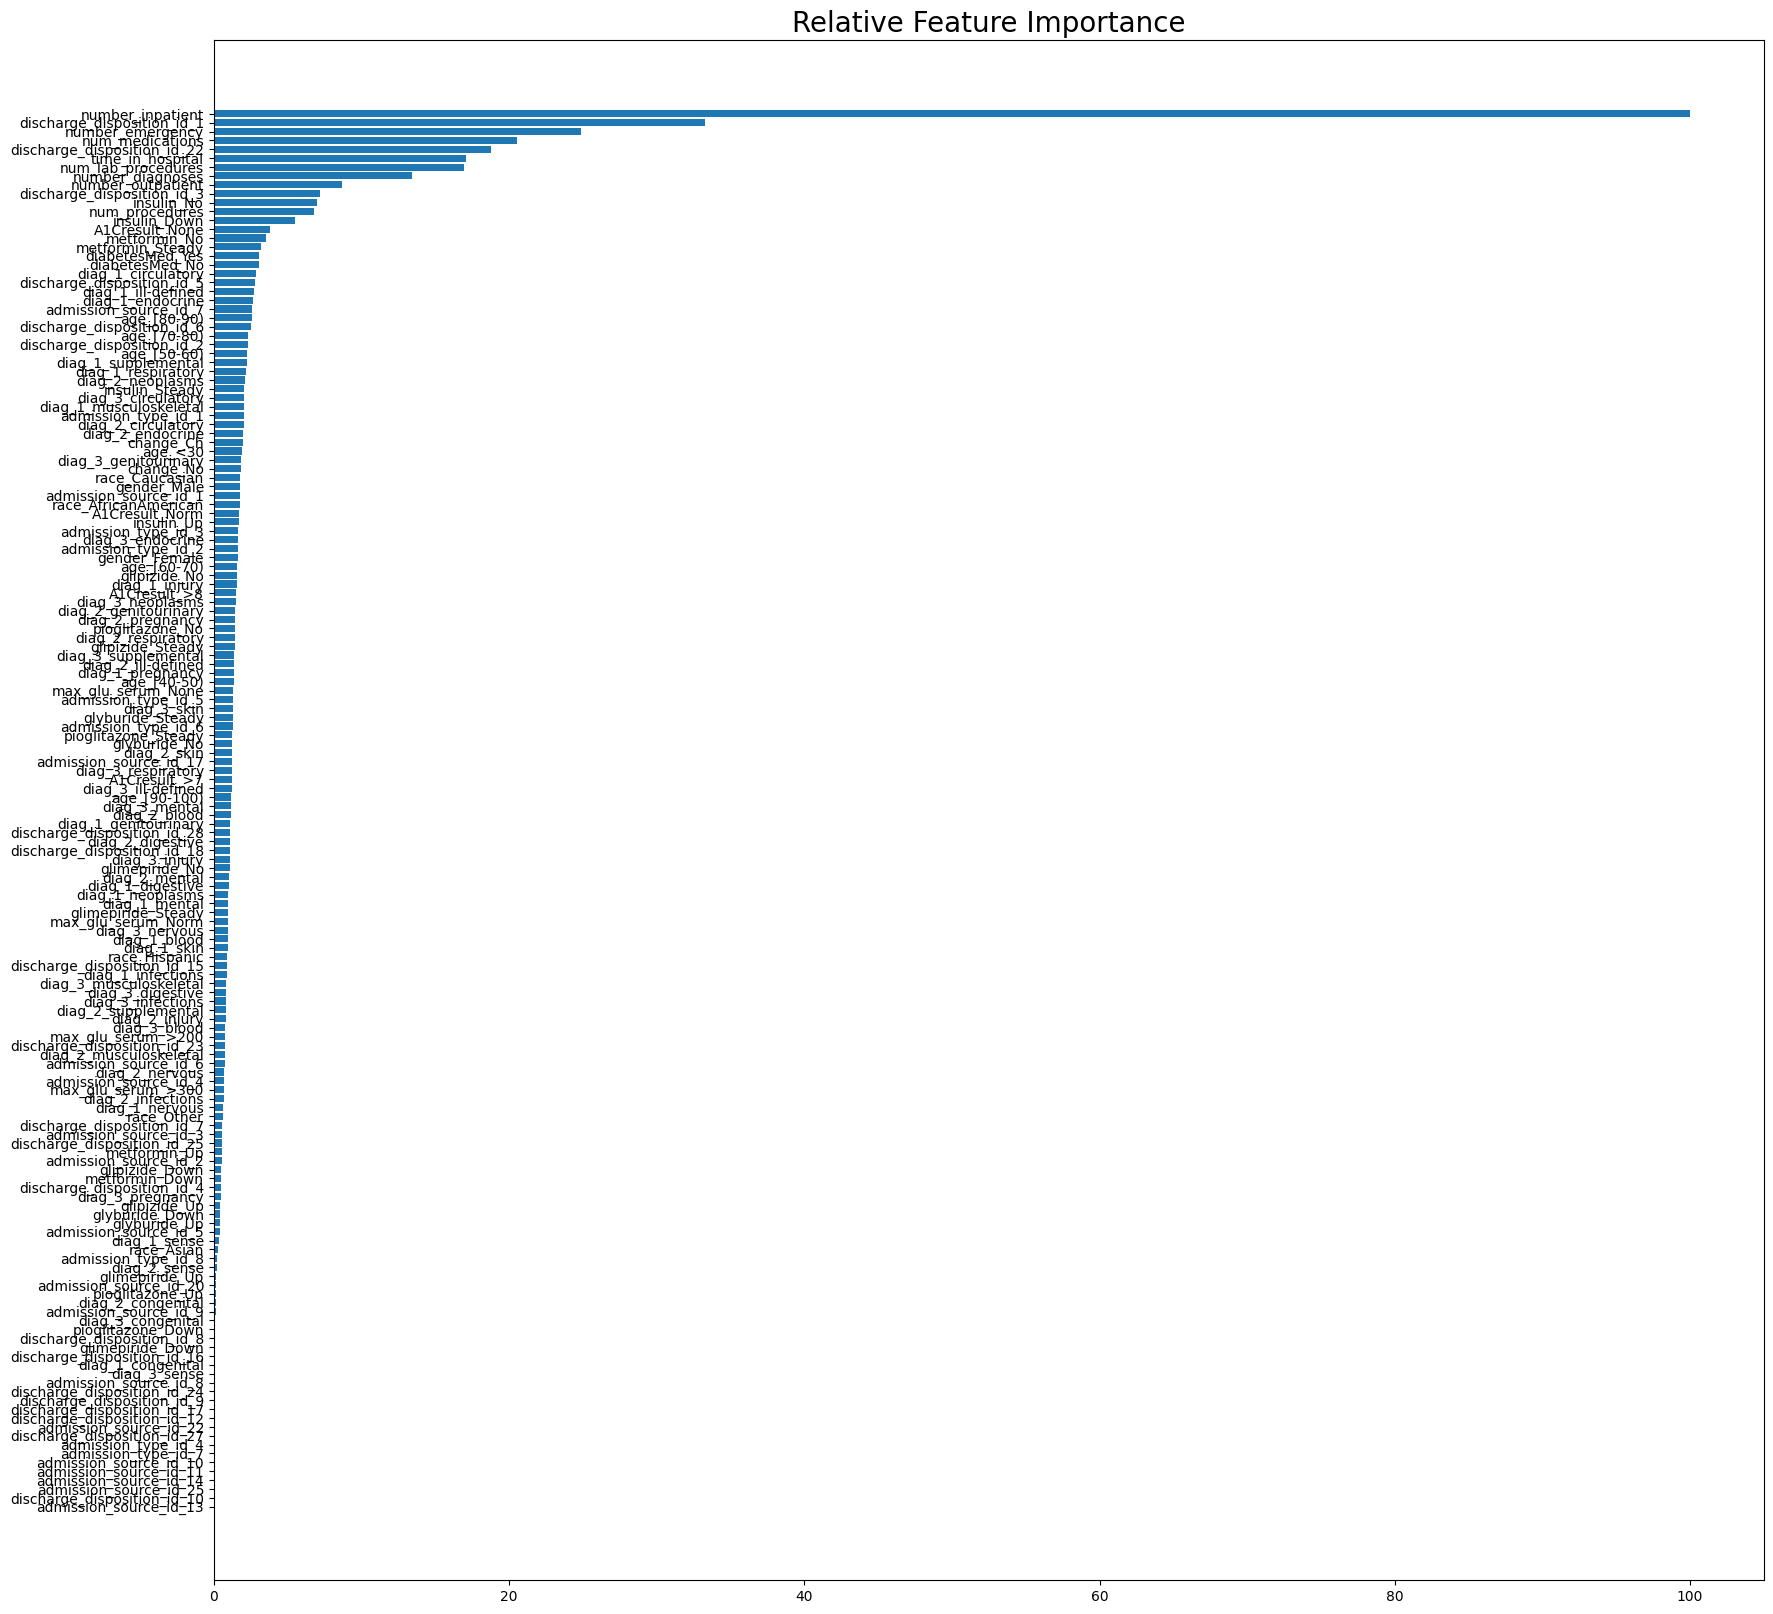

In [37]:
print("ROC AUC score:", roc_auc_score(y_test, rf_hp_preds_proba))

# plot relative feature importance
importances = rf_random.best_estimator_.feature_importances_
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
feature_names = list(X_train.columns.values)
feature_names_sort = [feature_names[indice] for indice in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
print('Top 10 features are: ')
for feature in feature_names_sort[::-1][:10]:
    print(feature)
plt.figure(figsize=(20, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names_sort)
plt.title('Relative Feature Importance', fontsize=20)
plt.show()